In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster \
    import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import InterclusterDistance
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

#import os
#from comet_ml import Experiment
#from dotenv import load_dotenv

In [78]:
#load_dotenv()
#API_KEY = os.getenv('COMET_API_KEY')
#experiment = Experiment(
#    api_key=API_KEY,
#    project_name='bzcat',
#    workspace='dkudryavtsev',
#)

In [79]:
bzcat = pd.read_csv('data/bzcat_clean_noNaN.csv')
bzcat.drop(columns=['Unnamed: 0', 'RA_sin', 'RA_cos', 'Dec_sin'], 
           inplace=True)

In [80]:
bzcat.columns

Index(['BZCAT5 Source name', 'Class', 'Rad_opt_sp_index', 'alpha_2.3-4.8',
       'alpha_4.8-7.7', 'var_4.8', 'var_7.7', 'comoving_distance_Mpc', 'g-r',
       'r-i', 'i-z', 'z-y', 'y-w1', 'w1-w2', 'w2-w3', 'w3-w4', 'g_var',
       'r_var', 'i_var', 'z_var', 'y_var', 'Opt_uv_sp_index',
       'Opt_X_sp_index'],
      dtype='object')

In [81]:
alphas = ['alpha_2.3-4.8', 'alpha_4.8-7.7'] #, 'alpha_7.7-11.2', 'alpha_11.2-21.7']
radio_vars = ['var_4.8', 'var_7.7']
colors_panstarrs = ['g-r', 'r-i', 'i-z', 'z-y']
colors_wise = ['w1-w2', 'w2-w3', 'w3-w4']
opt_vars = ['g_var', 'r_var', 'i_var', 'z_var', 'y_var']

**Scaling**

In [82]:
cols = list(bzcat.columns)
cols.remove('BZCAT5 Source name')
cols.remove('Class')
mm_scaler = MinMaxScaler()
bzcat_scaled = pd.DataFrame(mm_scaler.fit_transform(bzcat[cols]), columns=cols)

**PCA**

In [83]:
cols = [
    'Rad_opt_sp_index', #'alpha_2.3-4.8', 'alpha_4.8-7.7', 
    'comoving_distance_Mpc', 'y-w1', 'Opt_uv_sp_index', 'Opt_X_sp_index'
]
model_df = bzcat_scaled[cols]
model_df = model_df.copy()

In [84]:
pca = PCA(n_components=1)
model_df['alphas'] = pca.fit_transform(bzcat_scaled[alphas])
model_df['radio_var'] = pca.fit_transform(bzcat_scaled[radio_vars])
model_df['color_panstarrs'] = pca.fit_transform(bzcat_scaled[colors_panstarrs])
model_df['color_wise'] = pca.fit_transform(bzcat_scaled[colors_wise])
model_df['opt_var'] = pca.fit_transform(bzcat_scaled[opt_vars])

cols_to_copy = ['alphas', 'radio_var','color_panstarrs', 'color_wise', 'opt_var']
bzcat[cols_to_copy] = model_df[cols_to_copy]

**Number of clusters**

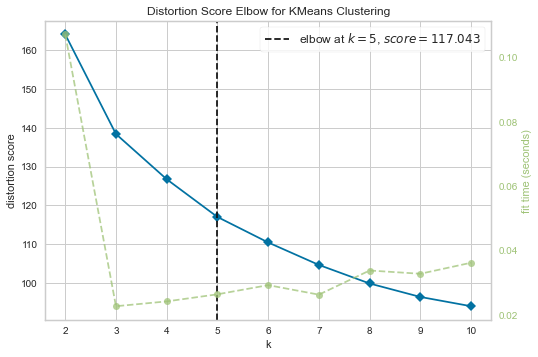

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [85]:
vis_distortion = KElbowVisualizer(KMeans())
vis_distortion.fit(model_df)
vis_distortion.show()

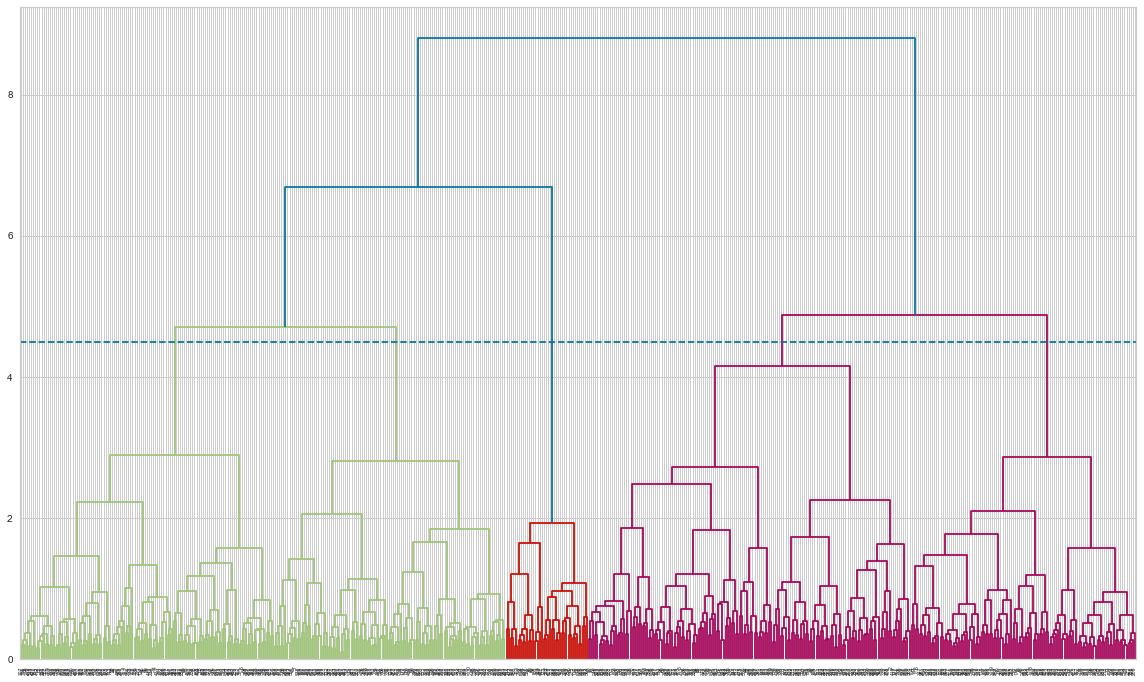

In [86]:
tree = AgglomerativeClustering(n_clusters=5, linkage='ward')
cl_pred = tree.fit_predict(model_df)
bzcat['cluster_tree'] = cl_pred

# linkage: single, complete, average, weighted, centroid, median, ward
linked = linkage(model_df, 'ward')
plt.figure(figsize=(20, 12))
dendrogram(Z=linked,
            orientation='top',
            #labels=cl_pred,
            distance_sort='descending')
plt.axhline(linestyle='--', y=4.5)
plt.show()

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



<AxesSubplot:xlabel='0', ylabel='1'>

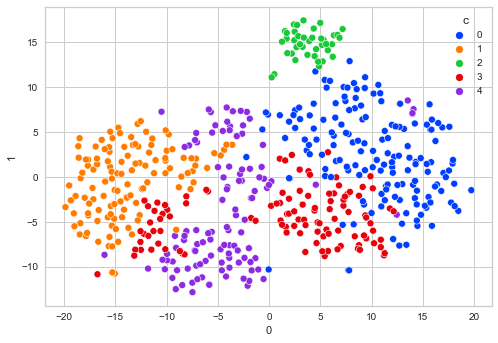

In [87]:
tsne = TSNE(n_components=2, perplexity=45, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
df_tsne['c'] = bzcat['cluster_tree']
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], hue=df_tsne['c'], 
    palette='bright')

**k-means, 5 clusters**

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



<AxesSubplot:xlabel='0', ylabel='1'>

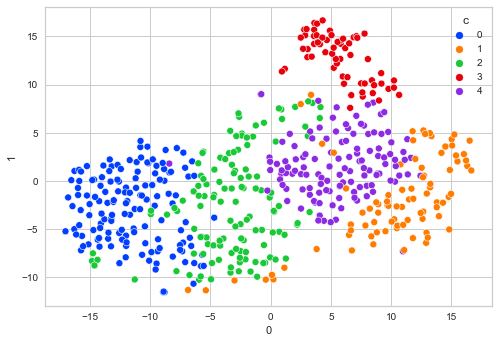

In [88]:
kmeans = KMeans(n_clusters=5, random_state=42)
bzcat['cluster_kmeans'] = kmeans.fit_predict(model_df)
tsne = TSNE(n_components=2, perplexity=50, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
df_tsne['c'] = bzcat['cluster_kmeans']
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], hue=df_tsne['c'], 
    palette='bright')

#experiment.log_figure(figure=plt)

In [89]:
kmeans = KMeans(n_clusters=5, random_state=42)
bzcat['cluster_kmeans'] = kmeans.fit_predict(model_df)
tsne = TSNE(n_components=3, perplexity=50, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
df_tsne['c'] = bzcat['cluster_kmeans']
fig = px.scatter_3d(x=df_tsne[0], y=df_tsne[1], z=df_tsne[2],
              color=df_tsne['c'], width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.show()

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



**Gaussian Mixture 5 components**

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



<AxesSubplot:xlabel='0', ylabel='1'>

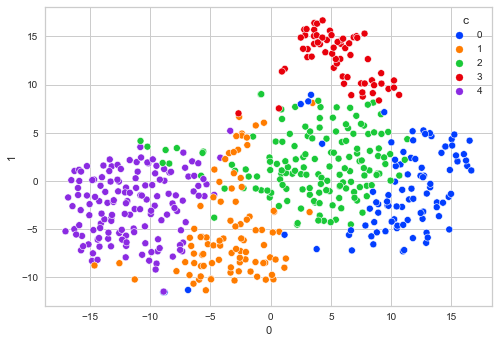

In [90]:
gmixture = GaussianMixture(n_components=5, covariance_type='spherical',
                           random_state=42)
bzcat['cluster_gm'] = gmixture.fit_predict(model_df)

tsne = TSNE(n_components=2, perplexity=50, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
df_tsne['c'] = bzcat['cluster_gm']
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], hue=df_tsne['c'], 
    palette='bright')

---

In [91]:
bzcat.drop(columns=['cluster_tree'], inplace=True)

In [92]:
bzcat[bzcat['Class']=='BZG']

,BZCAT5 Source name,Class,Rad_opt_sp_index,alpha_2.3-4.8,alpha_4.8-7.7,var_4.8,var_7.7,comoving_distance_Mpc,g-r,r-i,...,y_var,Opt_uv_sp_index,Opt_X_sp_index,alphas,radio_var,color_panstarrs,color_wise,opt_var,cluster_kmeans,cluster_gm
24,5BZGJ0056-0936,BZG,0.318,-0.158,-0.616,0.207,0.080,444.657331,0.584801,0.097401,...,-1.152330,0.989937,1.013858,-0.144072,-0.319352,0.045398,0.668289,-0.092733,3,3
42,5BZGJ0128+4901,BZG,0.392,0.277,0.290,0.225,0.359,291.812483,0.354199,0.667200,...,-0.820979,0.959472,0.964354,0.107445,-0.079788,-0.143939,0.030289,-0.257367,4,2
49,5BZGJ0152+0147,BZG,0.217,-0.258,0.132,0.115,0.023,347.328427,0.248801,0.529700,...,-2.371937,1.008062,1.003751,0.068582,-0.425324,-0.058893,0.614976,-0.099306,3,3
53,5BZGJ0202-0559,BZG,0.518,0.076,0.357,0.032,0.341,798.379037,0.720700,0.731201,...,-0.808110,0.957203,0.963879,0.128584,-0.219111,-0.166953,0.120602,-0.274064,4,2
54,5BZGJ0204+4005,BZG,0.153,-0.129,0.701,0.030,0.075,30.928646,0.450101,0.353499,...,-1.048394,0.988678,0.969818,0.228114,-0.437724,0.028493,0.420550,-0.064451,3,3
76,5BZGJ0312+3615,BZG,0.121,0.176,0.012,0.182,0.116,308.932932,0.456499,0.380001,...,-1.131031,0.979094,1.001899,0.029915,-0.306082,0.008997,0.737517,-0.122131,3,3
82,5BZGJ0401-1606,BZG,-0.039,-0.031,0.368,0.207,0.381,140.553664,0.777200,0.065101,...,-1.997307,0.948400,0.889945,0.132861,-0.073436,0.121795,0.530179,0.131918,3,3
113,5BZGJ0654+4247,BZG,0.289,-0.095,-0.347,0.107,0.253,540.839983,0.551000,0.197200,...,-1.265850,0.993373,0.939955,-0.068674,-0.242580,0.016006,0.415552,0.089308,3,3
114,5BZGJ0656+4237,BZG,0.075,-0.338,-0.682,0.220,0.443,257.468872,0.525899,0.211100,...,-0.090582,0.971069,0.968588,-0.160780,-0.014388,-0.051005,0.735586,-0.168064,3,3
135,5BZGJ0809+3455,BZG,0.368,0.024,-0.557,0.472,0.462,360.088228,0.594801,0.306899,...,-0.385220,0.997595,1.037857,-0.129366,0.163848,-0.030836,0.589407,-0.058633,3,3


In [93]:
bzcat[bzcat['cluster_kmeans']==0]['Class'].value_counts()


BZQ    142
Name: Class, dtype: int64

In [94]:
bzcat[bzcat['cluster_kmeans']==1]['Class'].value_counts()

BZQ      60
BLLac    19
BZU       6
BZG       3
Name: Class, dtype: int64

In [95]:
bzcat[bzcat['cluster_kmeans']==2]['Class'].value_counts()

BZQ      113
BZU        8
BLLac      5
Name: Class, dtype: int64

In [96]:
bzcat[bzcat['cluster_kmeans']==3]['Class'].value_counts()

BLLac      26
BZG        19
BZU        13
BLLac_c     2
BZQ         1
Name: Class, dtype: int64

In [97]:
bzcat[bzcat['cluster_kmeans']==4]['Class'].value_counts()

BZQ      101
BLLac      9
BZU        9
BZG        4
Name: Class, dtype: int64

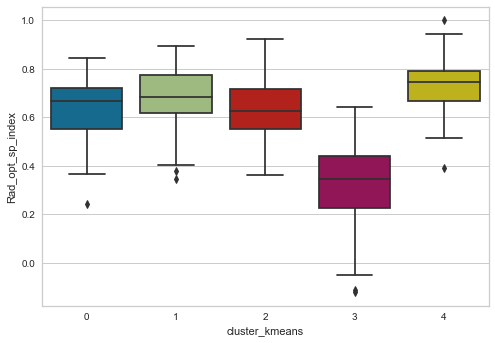

In [98]:
sns.boxplot(data=bzcat, y='Rad_opt_sp_index', x='cluster_kmeans');
#experiment.log_figure(figure=plt)

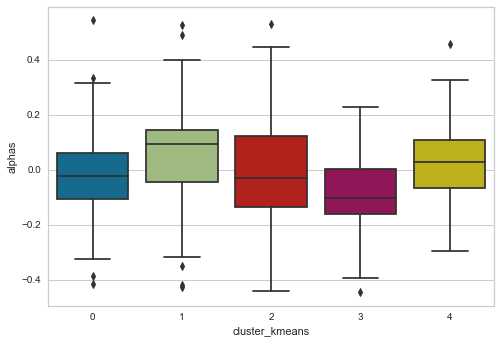

In [99]:
sns.boxplot(data=bzcat, y='alphas', x='cluster_kmeans');
#experiment.log_figure(figure=plt)

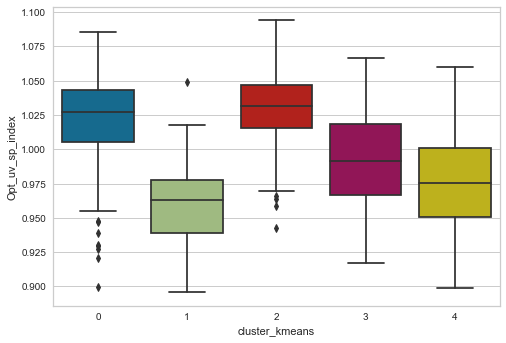

In [100]:
sns.boxplot(data=bzcat, y='Opt_uv_sp_index', x='cluster_kmeans');
#experiment.log_figure(figure=plt)

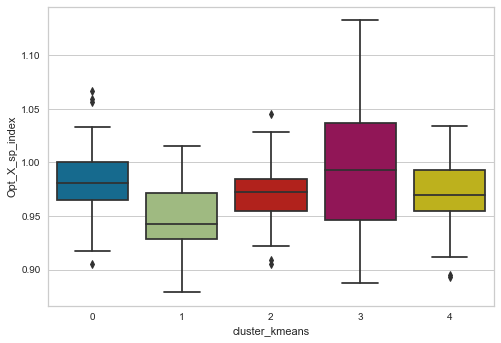

In [101]:
sns.boxplot(data=bzcat, y='Opt_X_sp_index', x='cluster_kmeans');
#experiment.log_figure(figure=plt)

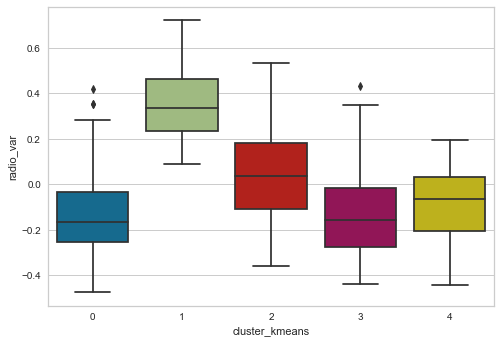

In [102]:
sns.boxplot(data=bzcat, y='radio_var', x='cluster_kmeans');
#experiment.log_figure(figure=plt)

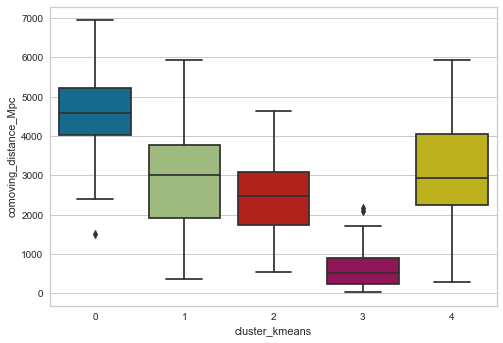

In [103]:
sns.boxplot(data=bzcat, y='comoving_distance_Mpc', x='cluster_kmeans');
#experiment.log_figure(figure=plt)

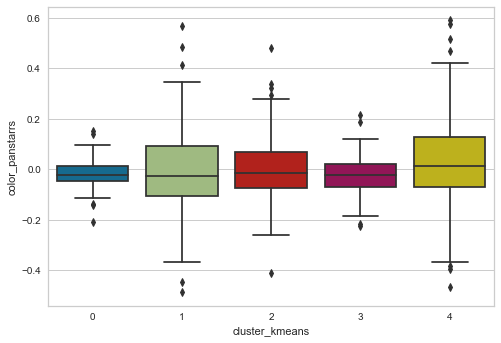

In [104]:
sns.boxplot(data=bzcat, y='color_panstarrs', x='cluster_kmeans');
#experiment.log_figure(figure=plt)

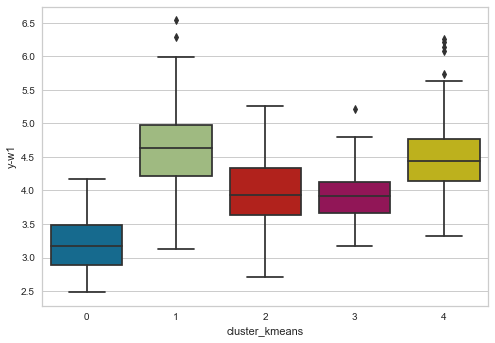

In [105]:
sns.boxplot(data=bzcat, y='y-w1', x='cluster_kmeans');
#experiment.log_figure(figure=plt)

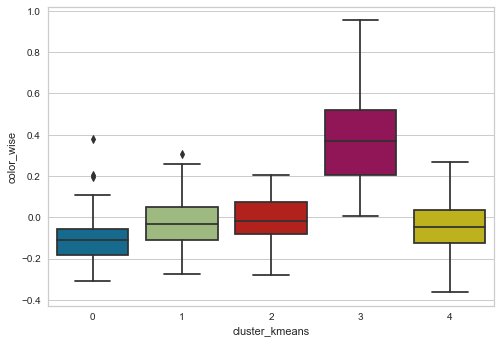

In [106]:
sns.boxplot(data=bzcat, y='color_wise', x='cluster_kmeans');
#experiment.log_figure(figure=plt)

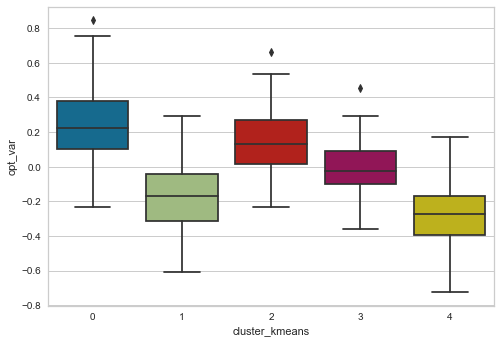

In [107]:
sns.boxplot(data=bzcat, y='opt_var', x='cluster_kmeans');
#experiment.log_figure(figure=plt)

In [108]:
#experiment.end()